<a href="https://colab.research.google.com/github/gee-siqi/20745634_Siqi_Bao/blob/main/Assignment_gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/irl')

In [3]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from tqdm import tqdm
import time

size_board = 4



## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [4]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## Initialization

In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

np.random.seed(22)  ## Set the random seed

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES


## INITALISE YOUR NEURAL NETWORK...
W1 = np.random.randn(N_h, N_in) * np.sqrt(1/N_in)
W2 = np.random.randn(N_a, N_h) * np.sqrt(1/N_h)

# Initialize the biases
bias_W1 = np.zeros((N_h,))
bias_W2 = np.zeros((N_a,))

# Initialize the target nueral network with the same way
W1_tar = np.random.randn(N_h, N_in) * np.sqrt(1 / (N_in))
W2_tar = np.random.randn(N_a, N_h) * np.sqrt(1 / (N_h))
bias_W1_tar = np.zeros((N_h,))
bias_W2_tar = np.zeros((N_a,))


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
# Change gamma from 0.85 to 0.4
gamma = 0.4        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save_Q = np.zeros([N_episodes, 1])
N_moves_save_Q = np.zeros([N_episodes, 1])


In [6]:
#epsilon greedy policy(for greedy policy: epsilon == 1)
# Random array to decide whether the choice is greedy or random
#rand_array = np.random.rand(N_episodes+10000)

def epsilon_greedy(epsilon, allowed_a, x):
      a,_=np.where(allowed_a==1)
      if epsilon > np.random.uniform(0,1):
          a_agent=np.random.permutation(a)[0]  
      else:
          #select allowed actions
          a_a = np.zeros([32, ])
          for j in a:
              a_a[j] = x[j] # Only keep q values of allowed actions
          if a_a.any() == 0:
              a_agent=np.random.permutation(a)[0]
          else:
              a_agent = np.argmax(a_a)
      return a_agent

# Then epsilon_greedy(0, allowed_a, x, 0) would be the greedy policy

## Q-Learning

In [7]:
for n in tqdm(range(N_episodes)):
    
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done == 0:


        #nueral activation: input layer to hidden layer
        h1 = np.dot(W1, X) + bias_W1
        #relu
        x1 = (h1 > 0) * h1
        #nueral activation: hidden layer to output layer
        h2 = np.dot(W2, x1) + bias_W2
        #relu
        x2 = (h2 > 0) * h2   ##Q(s, :)
        
        # Use epsilon-greedy policy to choose an action
        #Set index as i+N to make sure each epsilon greedy policy is random
        a = epsilon_greedy(epsilon_f, allowed_a, x2)

        # Make an action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)

        # One hot code with action index = 1 as mask
        mask = np.zeros((N_a, ))
        mask[a] = 1  
        
        if Done == 1:
            Q_bar = x2[a] #predicted Q value ##Q(s, a)
            #calculate the error signal
            e_n = R - Q_bar
            
            # Backpropagation: output layer -> hidden layer
            g_relu2 = np.array(h2, copy = True)
            g_relu2[h2 >0] = 1
            g_relu2[h2 <=0] = 0
            delta2 = g_relu2 * e_n * mask
            
            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2
            
            # Backpropagation: hidden layer -> input layerg_relu2 = np.array(h2, copy = True)
            g_relu1 = np.array(h1, copy = True)
            g_relu1[h1 >0] = 1
            g_relu1[h1 <=0] = 0
            delta1 = g_relu1 * np.dot(W2.T, delta2)

            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1
            
            W1 += eta * dW1
            W2 += eta * dW2
            bias_W1 += eta * dbias_W1
            bias_W2 += eta * dbias_W2
            
            R_save_Q[n] = np.copy(R) #saving variables
            N_moves_save_Q[n] = np.copy(i)
            #print('episoid:',n+1,'; R:',R,'; Number of steps: ',i)
            break
            
        else:
            #update step number
            i += 1
          
            # Same neraul activation
            h1_tar = np.dot(W1, X_next) + bias_W1
            x1_tar = (h1_tar > 0) * h1_tar
            h2_tar = np.dot(W2, x1_tar) + bias_W2
            x2_tar = (h2_tar > 0) * h2_tar
            
            #use greedy policy to eatimate action at S'
            a2 = epsilon_greedy(-10, allowed_a_next, x2_tar)
            
            # Compute the error signal
            Q_bar = x2[a]
            Q_tar = R + gamma * x2_tar[a2] 
            e_n = Q_tar - Q_bar

            # Backpropagation: output layer -> hidden layer
            g_relu2 = np.array(h2, copy = True)
            g_relu2[h2 >0] = 1
            g_relu2[h2 <=0] = 0
            delta2 = g_relu2 * e_n * mask
            
            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2
            
            # Backpropagation: hidden layer -> input layer
            g_relu1 = np.array(h1, copy = True)
            g_relu1[h1 >0] = 1
            g_relu1[h1 <=0] = 0
            delta1 = g_relu1 * np.dot(W2.T, delta2)

            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W1 += eta * dW1
            W2 += eta * dW2
            bias_W1 += eta * dbias_W1
            bias_W2 += eta * dbias_W2
            
        # Pass state values to the next step
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
        

100%|██████████| 100000/100000 [11:52<00:00, 140.44it/s]


In [16]:
print('Q-Learning, Average reward:',np.mean(R_save_Q),'Number of steps: ',np.mean(N_moves_save_Q))

Q-Learning, Average reward: 0.76212 Number of steps:  3.34529


In [9]:
def ema(data, alpha):
    n = len(data)
    ema = np.zeros((n, ))
    for i in range(n):
      if i == 0:
        ema[i] = data[i]
      else:
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]
    return ema

In [26]:
#exponential moving average
alpha = 100/N_episodes

R_EMA_Q = ema(R_save_Q, alpha)
steps_EMA_Q = ema(N_moves_save_Q, alpha)

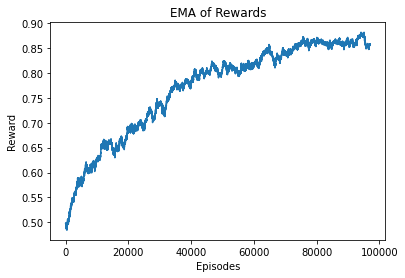

In [27]:
plt.plot(R_EMA_Q[3000:])
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('EMA of Rewards')
plt.show()

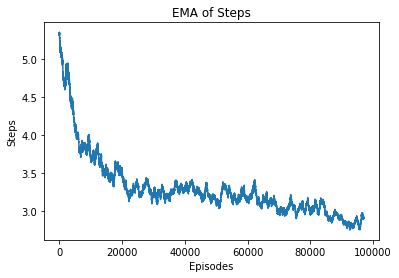

In [28]:
plt.plot(steps_EMA_Q[3000:])
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('EMA of Steps')
plt.show()